In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 16, 16)
latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!
# clover_term = clover.add_I(clover=torch.zeros_like(clover_term))  # test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=verbose, max_iter=50, max_restarts=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x8
  Level 1: 4x8x4x8
self.grid_list:[[8, 8, 8, 8], [8, 4, 8, 4]]
local_ortho_null_vecs.shape,src_c.shape,dest_f.shape:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), torch.Size([12, 8, 4, 8, 4]), torch.Size([12, 8, 8, 8, 8]))
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
_src_f.shape:torch.Size([12, 8, 8, 8, 8])
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
_src_f.shape:torch.Size([12, 8, 8, 8, 8])
restrict:shape,coarse_dof:(torch.Size

In [3]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [4]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

BICGSTAB:Iteration 0: Residual = 7.024319e+01, Time = 0.015935 s
BICGSTAB:Iteration 1: Residual = 2.905225e+01, Time = 0.012393 s
BICGSTAB:Iteration 2: Residual = 2.980262e+01, Time = 0.012641 s
BICGSTAB:Iteration 3: Residual = 1.825408e+01, Time = 0.015158 s
BICGSTAB:Iteration 4: Residual = 1.138490e+01, Time = 0.014076 s
BICGSTAB:Iteration 5: Residual = 8.122712e+00, Time = 0.014604 s
BICGSTAB:Iteration 6: Residual = 7.017367e+00, Time = 0.018278 s
BICGSTAB:Iteration 7: Residual = 2.674677e+01, Time = 0.012504 s
BICGSTAB:Iteration 8: Residual = 1.678510e+01, Time = 0.014110 s
BICGSTAB:Iteration 9: Residual = 8.492451e+00, Time = 0.013680 s
BICGSTAB:Iteration 10: Residual = 2.925014e+00, Time = 0.014901 s
BICGSTAB:Iteration 11: Residual = 3.803782e+00, Time = 0.019726 s
BICGSTAB:Iteration 12: Residual = 3.877853e+00, Time = 0.012942 s
BICGSTAB:Iteration 13: Residual = 3.431227e+00, Time = 0.013901 s
BICGSTAB:Iteration 14: Residual = 3.091306e+00, Time = 0.022936 s
BICGSTAB:Iteration 1


MG:Iteration 1:
V-cycle level 0, mg_size: [8, 8, 8, 8]
    Pre pre-smooth residual norm: 3.3299e+02
    Pre-smoothing...
    Post pre-smooth residual norm: 2.0561e+01
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
V-cycle level 1, mg_size: [8, 4, 8, 4]
    Pre-solve residual norm: 1.1412e+02
    Solving coarsest grid directly...

Performance Statistics:
Total iterations: 8
Total time: 0.025547 seconds
Average time per iteration: 0.003192 s
Final residual: 2.04e-07
    Post-solve residual norm: 1.2199e-05
prolong:shape,fine_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 1, 4, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
    Post post-smooth residual norm: 2.1413e+01
MG:Iteration 1 completed, residual norm: 2.1413e+01

MG:Iteration 2:
V-cycle level 0, mg_size: [8, 8, 8, 8]
    Pre pre-smooth residual norm: 2.1413e+01
    Pre-smoothing...
    Post pre-smooth residual norm: 3.4316e+00
restrict:shape,coarse_dof:(torch.Size([12, 12, 8, 1, 4, 2, 8, 

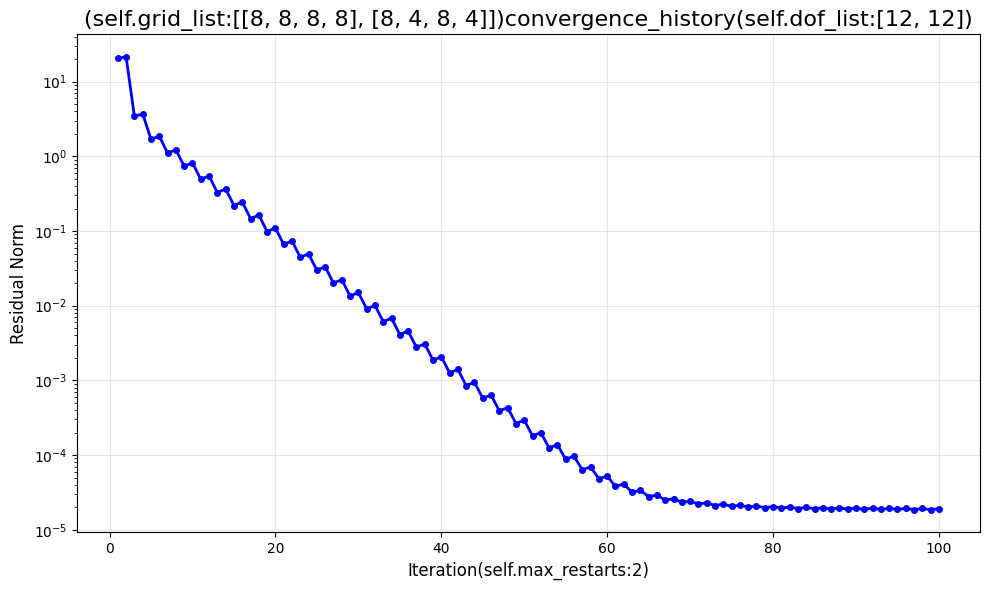

In [5]:
x = mg.solve()
mg.plot()

In [6]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

4.3218114292539007e-07


In [7]:
mg.b_list[-1].flatten()[:100]

tensor([ 1.2650e-08+3.2795e-08j, -9.9084e-08-5.9877e-08j,
         4.2181e-09-1.0521e-07j,  1.5583e-08+1.0998e-07j,
        -8.2274e-09-3.6072e-09j, -2.1537e-08-7.1985e-08j,
         1.4073e-08+3.5363e-08j, -2.7442e-08+1.4307e-07j,
        -6.4922e-08+3.5093e-09j, -1.3404e-07-4.7973e-08j,
         4.9072e-08+9.1048e-08j, -1.7059e-08-6.5749e-08j,
        -1.3163e-07+5.4000e-08j, -8.3270e-08+3.5156e-08j,
         3.9497e-08+1.8992e-08j, -2.8677e-08-1.1471e-07j,
         6.2450e-08-4.7162e-08j, -2.1118e-08-1.1179e-08j,
        -9.1983e-09-1.3948e-07j, -3.0032e-08+9.2746e-09j,
        -1.1692e-08-1.7053e-08j,  8.0062e-09+6.4880e-08j,
         6.2381e-08+6.3767e-08j, -5.9217e-08-2.3527e-07j,
         1.3118e-07-4.4007e-08j, -8.6474e-08+6.1021e-08j,
        -4.2443e-09-3.0257e-08j,  7.4930e-08+7.0669e-08j,
         7.0016e-08-1.4157e-08j,  9.4336e-08+4.6995e-08j,
         5.9028e-09+1.0222e-07j,  1.1499e-08-8.3989e-08j,
         1.2466e-09-7.0283e-09j, -7.0751e-09-3.9443e-08j,
         7.582